In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [122]:
dataset = pd.read_csv('../data/Final_Dataset/Predict_Avg_Eggs_Price_Dataset.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d')
print(f"Shape dataset: {dataset.shape}")
print(f"Dataset columns: {dataset.columns}")

Shape dataset: (926, 78)
Dataset columns: Index(['Gle_Trend_Brid_Flu', 'Wiki_Page_View_Eggs_Substitutes',
       'Gle_Trend_Chicken_Feed_Price', 'Gle_Trend_Eggs_Prices',
       'Gle_Trend_Eggs_Shortage', 'Wiki_Page_View_Bird_Flu',
       'Wiki_Page_View_Price_of_Eggs',
       'GDelt_Article_Count_seach_term_food_agri_livestock_infla_commo_supplychain',
       'GDelt_Sentiment_seach_term_food_agri_livestock_infla_commo_supplychain',
       'Rate_of_Lay_Eggs_100_Layer', 'Chicks_Hatched', 'Corn_Price_Received',
       'Average Price: Malt Beverages, All Types, All Sizes, Any Origin (Cost per 16 Ounces/473.2 Milliliters) in U.S. City Average',
       'Average Price: Wine, Red and White Table, All Sizes, Any Origin (Cost per 1 Liter/33.8 Ounces) in U.S. City Average',
       'Average Price: All Uncooked Beef Roasts (Cost per Pound/453.6 Grams) in U.S. City Average',
       'Average Price: All Uncooked Beef Steaks (Cost per Pound/453.6 Grams) in U.S. City Average',
       'Average Price: All

In [123]:
features = [# FRED
            "Global price of Corn",
            "Global price of Wheat",
            # "Global price of Barley",
            # "Global price of Soybean Meal",
            # "Global price of Rapeseed Oil",
            "Global price of Poultry",
            # "Producer Price Index by Commodity: Farm Products: Oats",
            # "Personal consumption expenditures: Food",
            # Google_Trends_Wikipedia_GDelt
            # "Gle_Trend_Brid_Flu",
            "Gle_Trend_Chicken_Feed_Price",
            "Gle_Trend_Eggs_Prices",
            # "Gle_Trend_Eggs_Shortage",
            # Other_Sources
            "Rate_of_Lay_Eggs_100_Layer",
            "Chicks_Hatched"]

target_variable = "Average Price: Eggs, Grade A, Large (Cost per Dozen) in U.S. City Average"

cols = 2
rows = (len(features) + 1) // cols

In [124]:
list_columns_to_keep = features + [target_variable]
filtered_dataset = dataset[list_columns_to_keep]
filtered_dataset = filtered_dataset[filtered_dataset.index >= '2012-01-01'] # Check if date good when change features

In [125]:
# Number of missing values for each column
missing_values_count = filtered_dataset.isnull().sum()
print(missing_values_count)

# Indices of missing values for each column
missing_values_indices = {col: filtered_dataset[col].isnull().where(filtered_dataset[col].isnull() == True).dropna().index.tolist() for col in filtered_dataset.columns}
for col, indices in missing_values_indices.items():
    print(f"Column: {col}, Missing Indices: {indices}")

Global price of Corn                                                         2
Global price of Wheat                                                        2
Global price of Poultry                                                      2
Gle_Trend_Chicken_Feed_Price                                                 0
Gle_Trend_Eggs_Prices                                                        0
Rate_of_Lay_Eggs_100_Layer                                                   2
Chicks_Hatched                                                               2
Average Price: Eggs, Grade A, Large (Cost per Dozen) in U.S. City Average    1
dtype: int64
Column: Global price of Corn, Missing Indices: [Timestamp('2025-01-01 00:00:00'), Timestamp('2025-02-01 00:00:00')]
Column: Global price of Wheat, Missing Indices: [Timestamp('2025-01-01 00:00:00'), Timestamp('2025-02-01 00:00:00')]
Column: Global price of Poultry, Missing Indices: [Timestamp('2025-01-01 00:00:00'), Timestamp('2025-02-01 00:00:00')]
Col

In [126]:
filtered_dataset = filtered_dataset.dropna()
print(f"Shape filtered_dataset: {filtered_dataset.shape}")

Shape filtered_dataset: (156, 8)


## Visualisation of the features values w.r.t. to the corresponding Index values

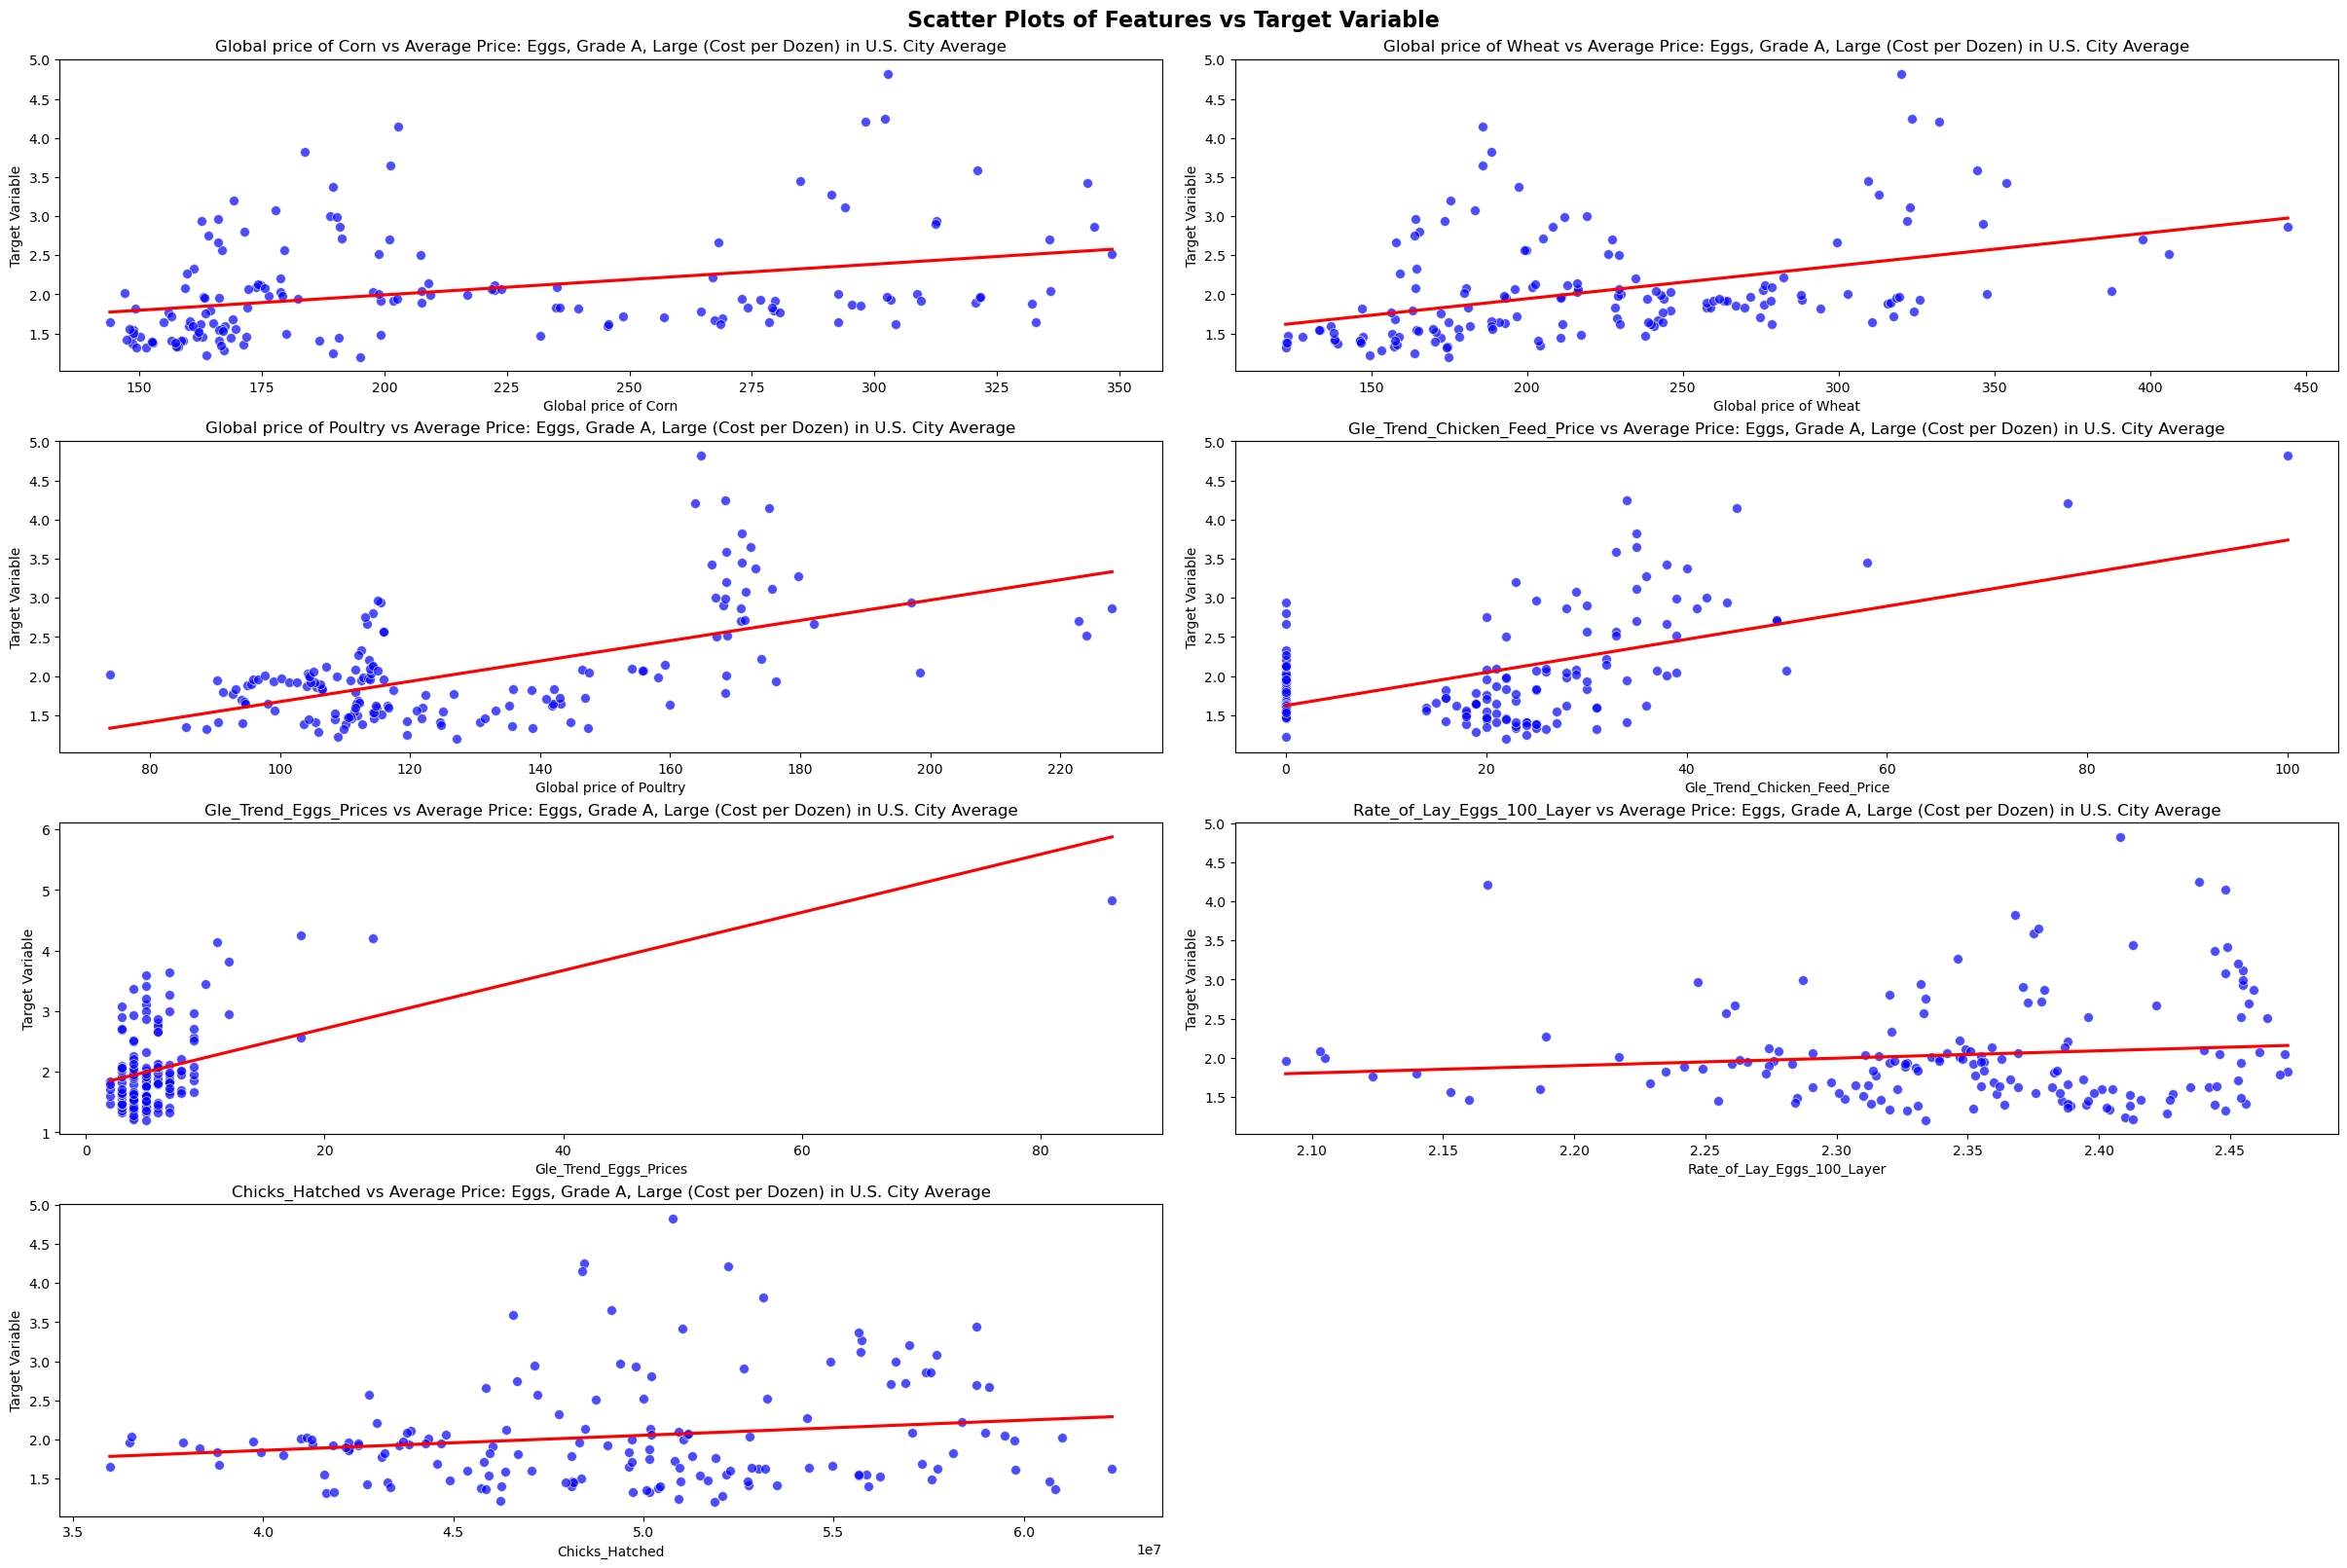

In [127]:
fig, axes = plt.subplots(rows, cols, figsize=(24, 16), constrained_layout=True)

for i, feature in enumerate(features):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    
    sns.scatterplot(data=filtered_dataset, x=feature, y=target_variable, ax=ax, color='blue', alpha=0.7, s=50)
    sns.regplot(data=filtered_dataset, x=feature, y=target_variable, scatter=False, ax=ax, color='red', ci=None)
    
    ax.set_title(f"{feature} vs {target_variable}", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Target Variable", fontsize=10)

for j in range(len(features), rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.suptitle("Scatter Plots of Features vs Target Variable", fontsize=16, weight='bold')
plt.show()

## Simple linear regressions for each pair of feature/target

In [128]:
model = LinearRegression()
results = []

for feature in features:
    X = filtered_dataset[[feature]]
    y = filtered_dataset[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train).fit()
    y_test_pred = model.predict(X_test)

    r2_train = model.rsquared
    r2_test = r2_score(y_test, y_test_pred)
    coef = model.params[feature]
    intercept = model.params['const']
    p_value = model.pvalues[feature]
    t_value = model.tvalues[feature]

    results.append({
        "Feature": feature,
        "Coefficient": coef,
        "Intercept": intercept,
        "t-value": t_value,
        "p-value": p_value,
        "R² (Train)": r2_train,
        "R² (Test)": r2_test
    })

In [129]:
results_df = pd.DataFrame(results)
results_df

,Feature,Coefficient,Intercept,t-value,p-value,R² (Train),R² (Test)
0,Global price of Corn,3.628440e-03,1.286956,3.850161,1.894053e-04,0.108342,0.129127
1,Global price of Wheat,4.017263e-03,1.161828,4.907740,2.883347e-06,0.164875,0.165976
2,Global price of Poultry,1.261944e-02,0.429027,7.934231,1.155304e-12,0.340369,0.316946
3,Gle_Trend_Chicken_Feed_Price,1.964683e-02,1.670774,5.851584,4.190262e-08,0.219155,0.382136
4,Gle_Trend_Eggs_Prices,1.062194e-01,1.475191,6.120308,1.169946e-08,0.234909,-1.276300
5,Rate_of_Lay_Eggs_100_Layer,9.343197e-01,-0.131069,1.373967,1.719712e-01,0.015238,-0.014454
6,Chicks_Hatched,1.789403e-08,1.176631,1.833603,6.915032e-02,0.026819,0.015677


### Multiple linear regression

In [130]:
# Adjust regarding previous plot and simple linear regressions results
features = [# FRED
            "Global price of Corn",
            "Global price of Wheat",
            # "Global price of Barley",
            # "Global price of Soybean Meal",
            # "Global price of Rapeseed Oil",
            "Global price of Poultry",
            # "Producer Price Index by Commodity: Farm Products: Oats",
            # "Personal consumption expenditures: Food",
            # Google_Trends_Wikipedia_GDelt
            # "Gle_Trend_Brid_Flu",
            "Gle_Trend_Chicken_Feed_Price",
            # "Gle_Trend_Eggs_Prices",
            # "Gle_Trend_Eggs_Shortage",
            # Other_Sources
            "Rate_of_Lay_Eggs_100_Layer",
            "Chicks_Hatched"]

In [131]:
X = filtered_dataset[features]
y = filtered_dataset[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_multiple = sm.OLS(y_train, X_train).fit()

print(model_multiple.summary())

                                                        OLS Regression Results                                                       
Dep. Variable:     Average Price: Eggs, Grade A, Large (Cost per Dozen) in U.S. City Average   R-squared:                       0.424
Model:                                                                                   OLS   Adj. R-squared:                  0.394
Method:                                                                        Least Squares   F-statistic:                     14.34
Date:                                                                       Wed, 19 Feb 2025   Prob (F-statistic):           3.35e-12
Time:                                                                               10:50:40   Log-Likelihood:                -90.266
No. Observations:                                                                        124   AIC:                             194.5
Df Residuals:                                                 

In [132]:
y_test_pred = model_multiple.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
print(f"R² on Test Set: {r2_test:.4f}")

R² on Test Set: 0.4924


# Check assumptions of multiple linear regression to say ok we can use it

#### Residual vs Fitted Values

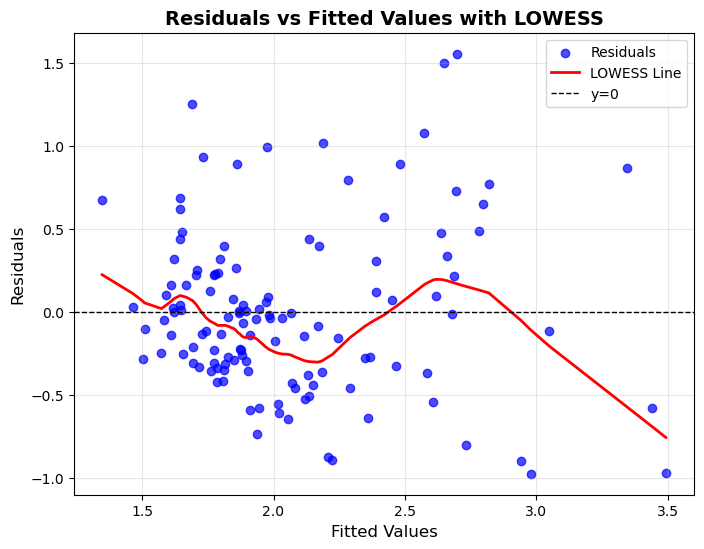

In [133]:
fitted_values = model_multiple.fittedvalues
residuals = model_multiple.resid
lowess_fit = lowess(residuals, fitted_values, frac=0.3)
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.7, color='blue', label='Residuals')
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='red', linewidth=2, label='LOWESS Line')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='y=0')
plt.title("Residuals vs Fitted Values with LOWESS", fontsize=14, weight='bold')
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Residual vs time plot

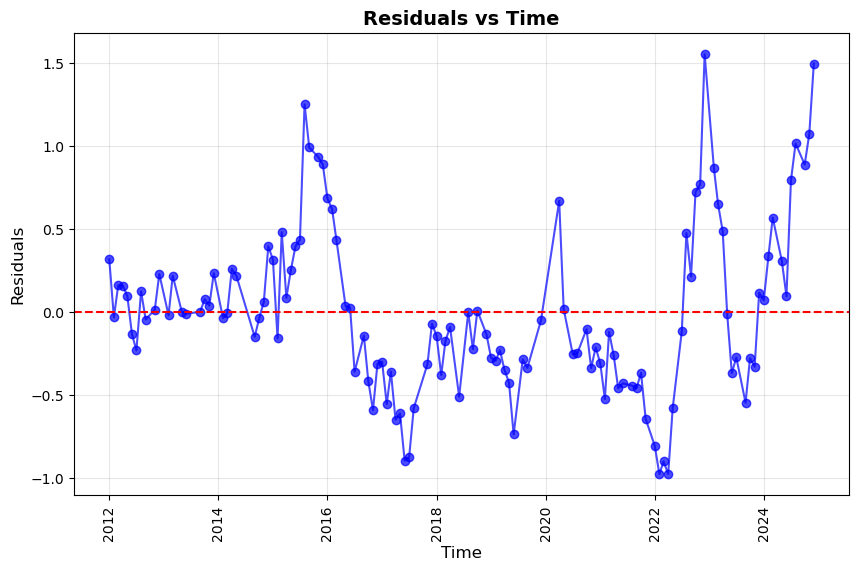

In [134]:
residuals_with_dates = filtered_dataset.loc[model_multiple.resid.index]
residuals_with_dates["residuals"] = model_multiple.resid.values
residuals_with_dates = residuals_with_dates.sort_index(ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(residuals_with_dates.index, residuals_with_dates["residuals"], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Time", fontsize=14, weight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.xticks(rotation=90)
plt.grid(alpha=0.3)
plt.show()

#### Normal Q-Q Plot

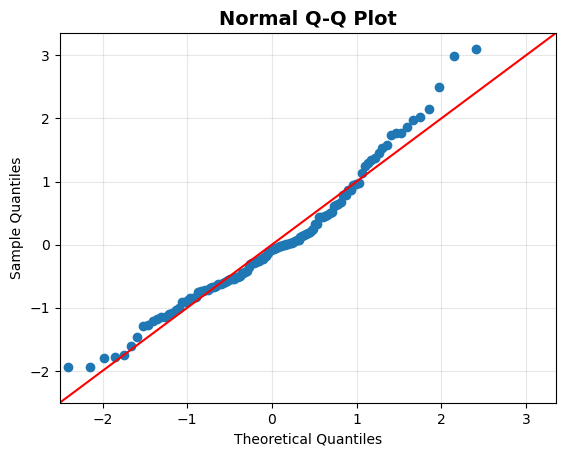

In [135]:
sm.qqplot(residuals, line='45', fit=True)
plt.title("Normal Q-Q Plot", fontsize=14, weight='bold')
plt.grid(alpha=0.3)
plt.show()

#### Scale Location Plot

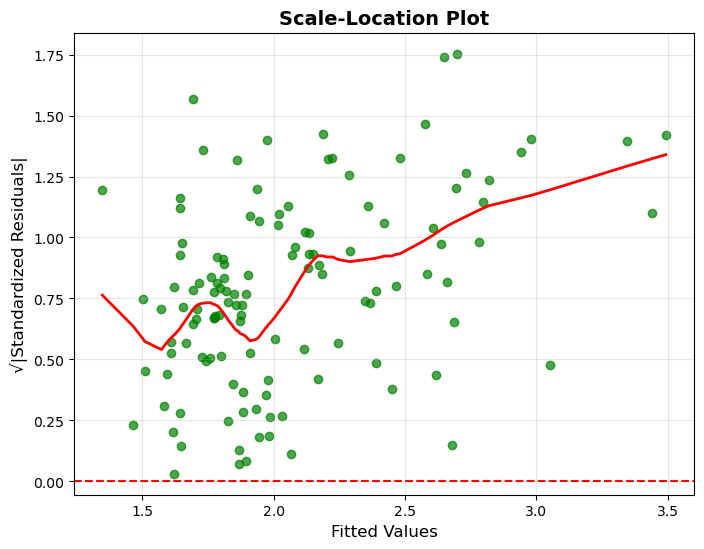

In [136]:
standardized_residuals = model_multiple.get_influence().resid_studentized_internal
abs_sqrt_residuals = np.sqrt(np.abs(standardized_residuals))
lowess_fit = lowess(abs_sqrt_residuals, fitted_values, frac=0.3)

plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, abs_sqrt_residuals, alpha=0.7, color='green')
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='red', linewidth=2, label='LOWESS Line')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Scale-Location Plot", fontsize=14, weight='bold')
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("√|Standardized Residuals|", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Residuals vs Leverage Plot

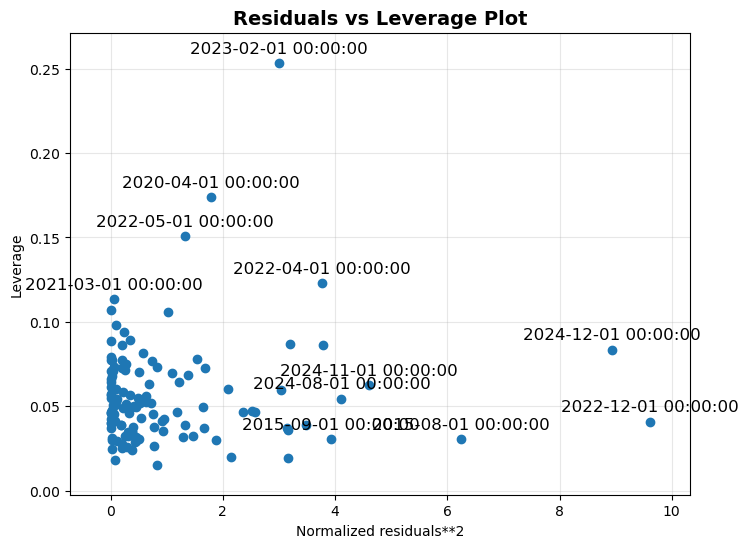

In [137]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_leverage_resid2(model_multiple, ax=ax)
plt.title("Residuals vs Leverage Plot", fontsize=14, weight='bold')
plt.grid(alpha=0.3)
plt.show()

### Multicollinearity among features

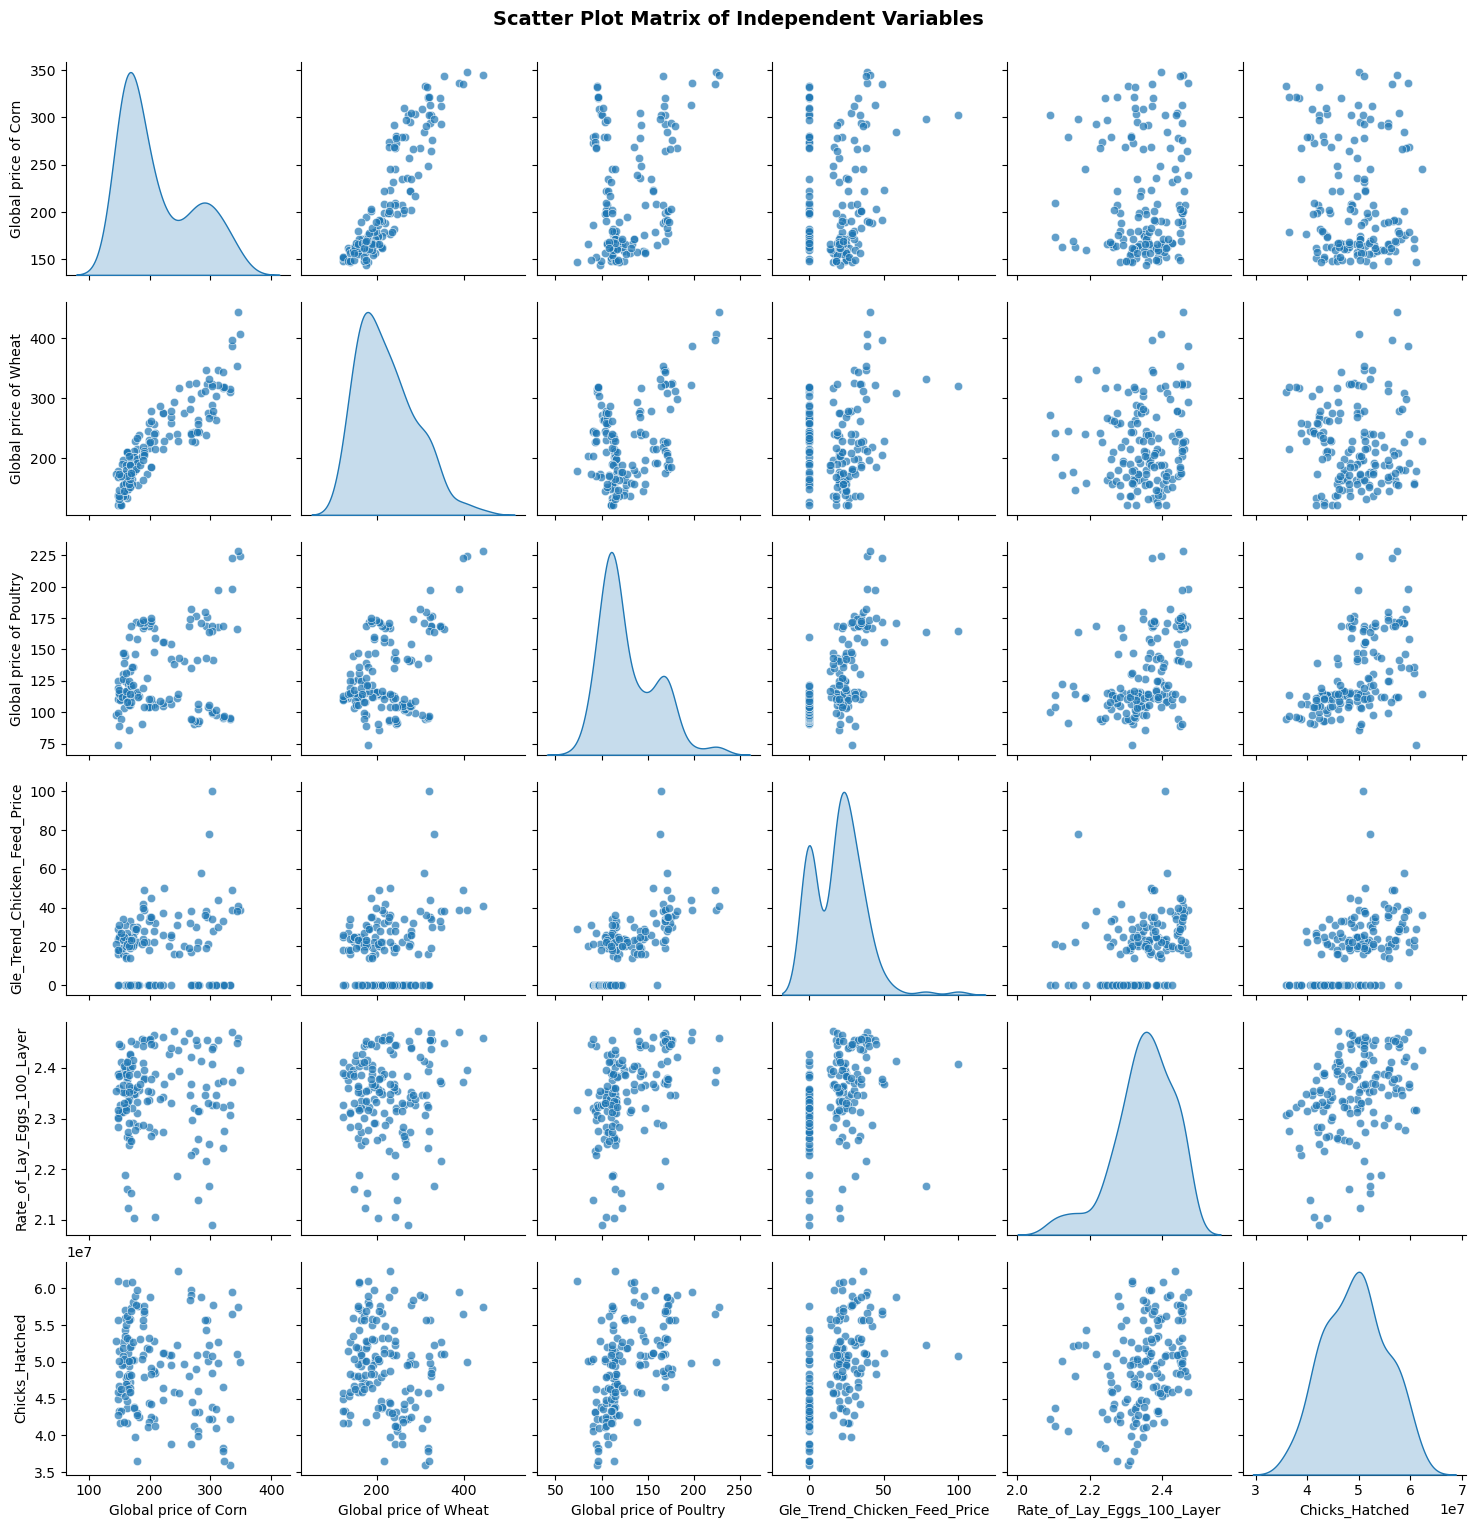

In [138]:
sns.pairplot(filtered_dataset[features], diag_kind='kde', plot_kws={'alpha': 0.7})
plt.suptitle("Scatter Plot Matrix of Independent Variables", y=1.02, fontsize=14, weight='bold')
plt.show()

## Global Analysis of the Multiple Regression

In [139]:
# Adjust regarding previous assumption checks
features = [# FRED
            "Global price of Corn",
            "Global price of Wheat",
            # "Global price of Barley",
            # "Global price of Soybean Meal",
            # "Global price of Rapeseed Oil",
            "Global price of Poultry",
            # "Producer Price Index by Commodity: Farm Products: Oats",
            # "Personal consumption expenditures: Food",
            # Google_Trends_Wikipedia_GDelt
            # "Gle_Trend_Brid_Flu",
            # "Gle_Trend_Chicken_Feed_Price",
            # "Gle_Trend_Eggs_Prices",
            # "Gle_Trend_Eggs_Shortage",
            # Other_Sources
            "Rate_of_Lay_Eggs_100_Layer",
            "Chicks_Hatched"]

In [140]:
X = filtered_dataset[features]
y = filtered_dataset[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_simple_cpi = sm.OLS(y_train, X_train).fit()

print(model_simple_cpi.summary())

                                                        OLS Regression Results                                                       
Dep. Variable:     Average Price: Eggs, Grade A, Large (Cost per Dozen) in U.S. City Average   R-squared:                       0.393
Model:                                                                                   OLS   Adj. R-squared:                  0.367
Method:                                                                        Least Squares   F-statistic:                     15.26
Date:                                                                       Wed, 19 Feb 2025   Prob (F-statistic):           1.49e-11
Time:                                                                               10:50:42   Log-Likelihood:                -93.517
No. Observations:                                                                        124   AIC:                             199.0
Df Residuals:                                                 

In [141]:
y_test_pred = model_simple_cpi.predict(X_test)
y_train_pred = model_simple_cpi.predict(X_train)

r2_test = r2_score(y_test, y_test_pred)
print(f"R² on Test Set: {r2_test:.4f}")

R² on Test Set: 0.3703


In [142]:
train_data = pd.DataFrame({
    #"Date": filtered_dataset.loc[y_train.index].index,
    "Actual": y_train.sort_index(),
    "Predicted": y_train_pred,
    "Dataset": "Train"
})

test_data = pd.DataFrame({
    #"Date": filtered_dataset.loc[y_test.index].index,
    "Actual": y_test.sort_index(),
    "Predicted": y_test_pred,
    "Dataset": "Test"
})

combined_data = pd.concat([train_data, test_data])
combined_data = combined_data.sort_index()

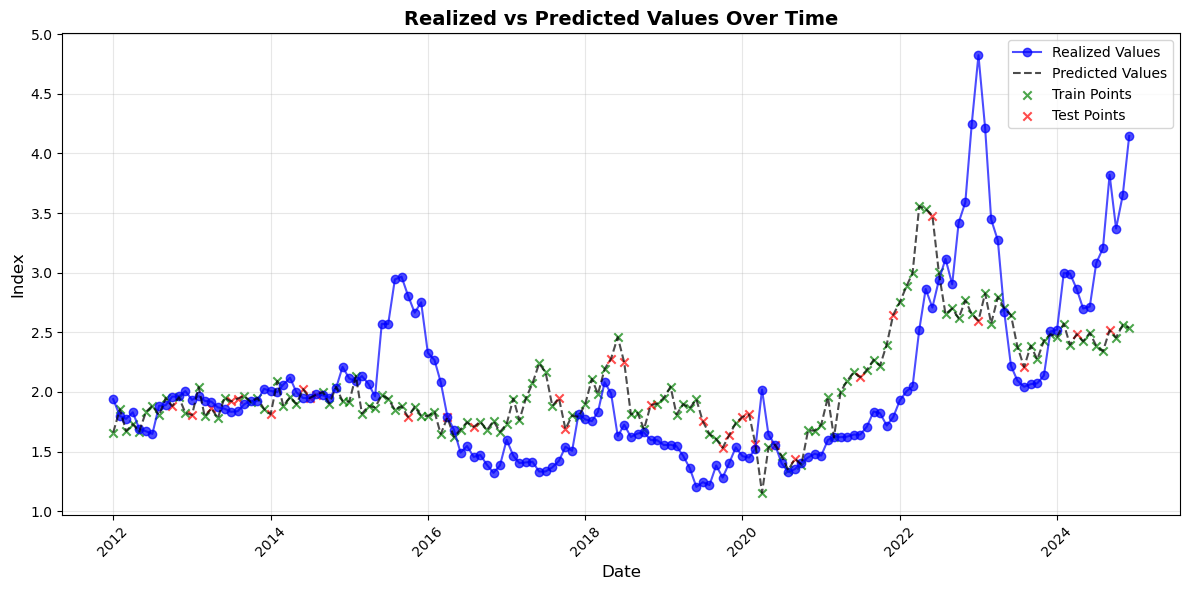

In [143]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data["Actual"], label="Realized Values", color='blue', linestyle='-', marker='o', alpha=0.7)
plt.plot(combined_data.index, combined_data["Predicted"], label="Predicted Values", color='black', linestyle='--', alpha=0.7)
plt.scatter(combined_data.index[combined_data["Dataset"] == "Train"],
            combined_data.loc[combined_data["Dataset"] == "Train", "Predicted"],
            color='green', label="Train Points", marker='x', alpha=0.7)
plt.scatter(combined_data.index[combined_data["Dataset"] == "Test"],
            combined_data.loc[combined_data["Dataset"] == "Test", "Predicted"],
            color='red', label="Test Points", marker='x', alpha=0.7)

plt.title("Realized vs Predicted Values Over Time", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Index", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Export Data

Export the dataset of historical prices of the features wee used in our final multiple linear regression

In [ ]:
final_dataset = filtered_dataset[features + [target_variable]]

final_dataset.to_csv('../data/Final_Dataset/Final_Dataset.csv')

Export prediction results vs realized egg prices

In [144]:
combined_data

combined_data.to_csv('../data/Final_Dataset/Combined_Data.csv')

,Actual,Predicted,Dataset
2012-01-01,1.939,1.658789,Train
2012-02-01,1.798,1.855035,Train
2012-03-01,1.774,1.670651,Train
2012-04-01,1.829,1.729555,Train
2012-05-01,1.691,1.667464,Train
...,...,...,...
2024-08-01,3.204,2.339584,Train
2024-09-01,3.821,2.516404,Test
2024-10-01,3.370,2.455490,Train
2024-11-01,3.649,2.560284,Train


Export the multiple linear regression estimates

In [145]:
# model_simple_cpi.summary()
# results_df = pd.DataFrame({
#     "Feature": features,
#     "Coefficient": model_simple_cpi.params[1:],  # Exclude the intercept
#     "Intercept": model_simple_cpi.params[0],
#     "t-value": model_simple_cpi.tvalues[1:],  # Exclude the intercept
#     "p-value": model_simple_cpi.pvalues[1:],  # Exclude the intercept
#     "R² (Train)": r2_train,
#     "R² (Test)": r2_test
# })

# results_df

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                        OLS Regression Results                                                       
=====================================================================================================================================
Dep. Variable:     Average Price: Eggs, Grade A, Large (Cost per Dozen) in U.S. City Average   R-squared:                       0.393
Model:                                                                                   OLS   Adj. R-squared:                  0.367
Method:                                                                        Least Squares   F-statistic:                     15.26
Date:                                                                       Wed, 19 Feb 2025   Prob (F-statistic):           1.49e-11
Time:                                                                               10:57:38   Log-Likelihood:                -93.517
No. Observations:                                                                        124   AIC:                             199.0
Df Residuals:                                                                            118   BIC:                             216.0
Df Model:                                                                                  5                                         
Covariance Type:                                                                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.8700      1.385      2.073      0.040       0.128       5.612
Global price of Corn          -0.0005      0.002     -0.274      0.784      -0.004       0.003
Global price of Wheat          0.0018      0.002      1.037      0.302      -0.002       0.005
Global price of Poultry        0.0136      0.002      6.083      0.000       0.009       0.018
Rate_of_Lay_Eggs_100_Layer    -0.9731      0.612     -1.589      0.115      -2.186       0.239
Chicks_Hatched             -1.177e-08   9.76e-09     -1.207      0.230   -3.11e-08    7.55e-09
==============================================================================
Omnibus:                       14.533   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.969
Skew:                           0.783   Prob(JB):                     0.000341
Kurtosis:                       3.799   Cond. No.                     1.58e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""